In [56]:
import torch
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt

def get_xor_data():
    x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
    y = torch.tensor([0, 1, 1, 0], dtype=torch.float32)
    return x, y

def get_2_layer_model():
    return torch.nn.Sequential(
    torch.nn.Linear(2, 2), torch.nn.Sigmoid(),
    torch.nn.Linear(2, 1), torch.nn.Sigmoid(),
    torch.nn.Flatten(start_dim=0, end_dim=1)
)

x, y = get_xor_data()
print(f'Items: {len(x)}')
loss_fn = torch.nn.MSELoss(reduction='mean')  #  none | mean | sum

Items: 4


In [67]:
def train(opt, n_epochs, name):
    loss_history = pd.Series(index=range(n_epochs), dtype=float, name=name)
    for i in range(n_epochs):
        pred = model(x)
        loss = loss_fn(pred, y)
        loss_history[i] = loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss_history

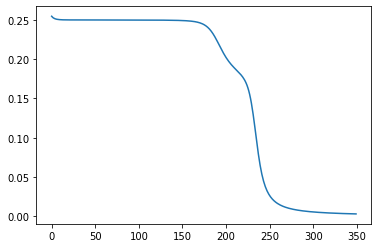

In [68]:
_ = torch.manual_seed(1)
model = get_2_layer_model()
optimizer = torch.optim.SGD(model.parameters(), lr=10)

loss = train(optimizer, 350, 'SGD')
_ = loss.plot()

## Момент (импульс)

реализует экспоненциальное сглаживание градиента.

Градиентный спуск:

$w_{i+1} = w_i - \eta \Delta w_i$

С моментом:

$v_{i+1} = \alpha v_i - \eta \Delta w_i$

$w_{i+1} = w_i + v_{i+1}$

Если градиенты сонаправлены, то их изменение ускоряется в $\frac {1} {1 - \alpha}$ раз

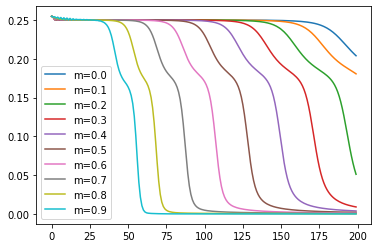

In [229]:
f, ax = plt.subplots(1,1)
for momentum in np.linspace(0.0, 0.9, 10):
    _ = torch.manual_seed(1)
    model = get_2_layer_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=10, momentum=momentum)
    loss = train(optimizer, n_epochs=200, name=f'm={momentum:.1f}')
    loss.plot(ax=ax)
_ = ax.legend()

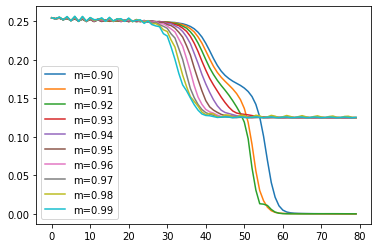

In [75]:
f, ax = plt.subplots(1,1)
for momentum in np.linspace(0.9, 0.99, 10):
    _ = torch.manual_seed(1)
    model = get_2_layer_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=10, momentum=momentum)
    loss = train(optimizer, n_epochs=80, name=f'm={momentum:.2f}')
    loss.plot(ax=ax)
_ = ax.legend()


## Момент Нестерова:

${w'}_i = w_i + \alpha v_i$

$v_{i+1} = \alpha v - \eta \Delta {w'}_i$

$w_{i+1} = w_i + v_{i+1} = {w'}_i - \eta \Delta {w'}_i$

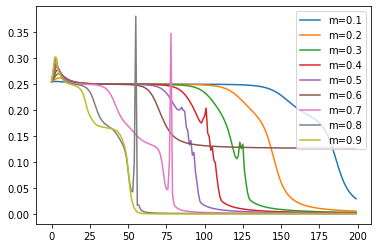

In [77]:
f, ax = plt.subplots(1,1)
for momentum in np.linspace(0.1, 0.9, 9):
    _ = torch.manual_seed(1)
    model = get_2_layer_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=10, momentum=momentum, nesterov=True)
    loss = train(optimizer, n_epochs=200, name=f'm={momentum:.1f}')
    loss.plot(ax=ax)
_ = ax.legend()

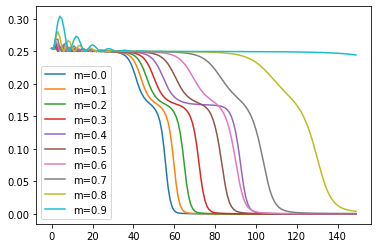

In [88]:
f, ax = plt.subplots(1,1)
for dampening in np.linspace(0, 0.9, 10):
    _ = torch.manual_seed(1)
    model = get_2_layer_model()
    optimizer = torch.optim.SGD(model.parameters(), lr=10, momentum=0.9, nesterov=False, dampening=dampening)
    loss = train(optimizer, n_epochs=150, name=f'm={dampening:.1f}')
    loss.plot(ax=ax)
_ = ax.legend()

# Адаптивная скорость обучения
## AdaGrad

$ r_i = {\sum_{k=0}^i  \left( \frac {\partial Q_i} {\partial w_i} \right) ^2 }$ -- аккумулированные градиенты

$ \Delta w_i = - \eta \times \frac {1} {\sqrt {r_{i+1}}} \times \frac {\partial Q_i} {\partial w_i}$

$ w_{i+1} = w_i + \Delta w_i $

Для параметров, по которым частная производная функции потерь наибольшая, скорость обучения уменьшается быстро, а если частная производная мала, то и скорость обучения уменьшается медленнее. В итоге больший прогресс получается в направлениях пространства параметров со сравнительно пологими склонами.

0.0052


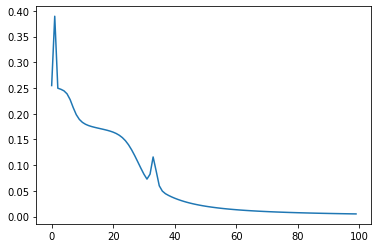

In [177]:
_ = torch.manual_seed(1)
model = get_2_layer_model()
optimizer = torch.optim.Adagrad(model.parameters(), lr=1.0)

loss = train(optimizer, 100, 'Adagrad')
_ = loss.plot()
print(f'{loss.iloc[-1]:.4f}')

## RMSProp

Призван улучшить поведение в невыпуклом случае

Сумма квадратов -> экспоненциальное сглаживание

$ r_{i+1} = \alpha r_i + (1 - \alpha) {\left( \frac {\partial Q} {\partial w_i} \right)}^2 $

0.0039


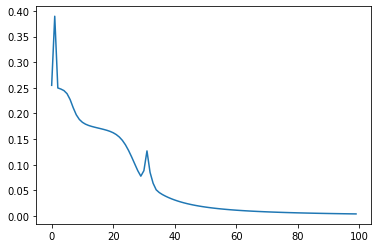

In [230]:
_ = torch.manual_seed(1)
model = get_2_layer_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.1, alpha=0.99)

loss = train(optimizer, 100, 'RMSprop')
_ = loss.plot()
print(f'{loss.iloc[-1]:.4f}')

## Adam

"adapive moments"

$\approx$ RMSProp + момент

1. Момент включен непосредственно в виде оценки первого момента (с экспоненциальными весами) градиента

$$ s_{i+1} = \alpha s_i + (1 - \alpha) \frac {\partial Q} {\partial w_i} $$


$$ r_{i+1} = \beta r_i + (1 - \beta) {\left( \frac {\partial Q} {\partial w_i} \right)}^2 $$

2. Включает поправку на смещение в оценки для учета их инициализации в начале координат

$$ \hat s = \frac s {1-\alpha} $$

$$ \hat r = \frac r {1-\beta} $$

$$ \Delta w = -eta \times \frac {1} {\sqrt {\hat r}} \times \hat s $$ 


0.0007


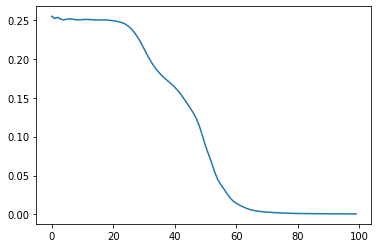

In [231]:
_ = torch.manual_seed(1)
model = get_2_layer_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.2, betas=(0.9, 0.999))

loss = train(optimizer, 100, 'Adam')
_ = loss.plot()
print(f'{loss.iloc[-1]:.4f}')

0.0012


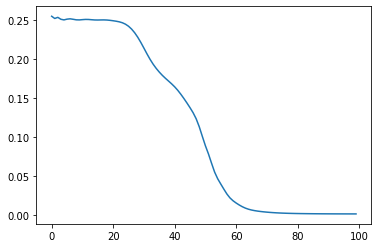

In [205]:
_ = torch.manual_seed(1)
model = get_2_layer_model()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.2)

loss = train(optimizer, 100, 'AdamW')
_ = loss.plot()
print(f'{loss.iloc[-1]:.4f}')

0.0025


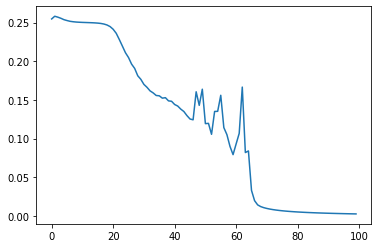

In [203]:
_ = torch.manual_seed(1)
model = get_2_layer_model()
optimizer = torch.optim.Adadelta(model.parameters(), lr=100, rho=0.9, eps=1e-06)

loss = train(optimizer, 100, 'Adadelta')
_ = loss.plot()
print(f'{loss.iloc[-1]:.4f}')

0.0072


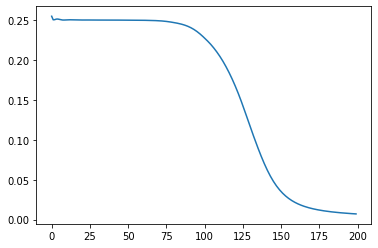

In [214]:
_ = torch.manual_seed(1)
model = get_2_layer_model()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.1)

loss = train(optimizer, 200, 'Adamax')
_ = loss.plot()
print(f'{loss.iloc[-1]:.4f}')